In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data as web

In [2]:
tickers = ["AAPL", "MSFT", "GOOG", "NVDA"]

In [3]:
data = pd.DataFrame()
for t in tickers:
    data[t] = web.DataReader(t, data_source="yahoo", start="2009-1-1")["Adj Close"]

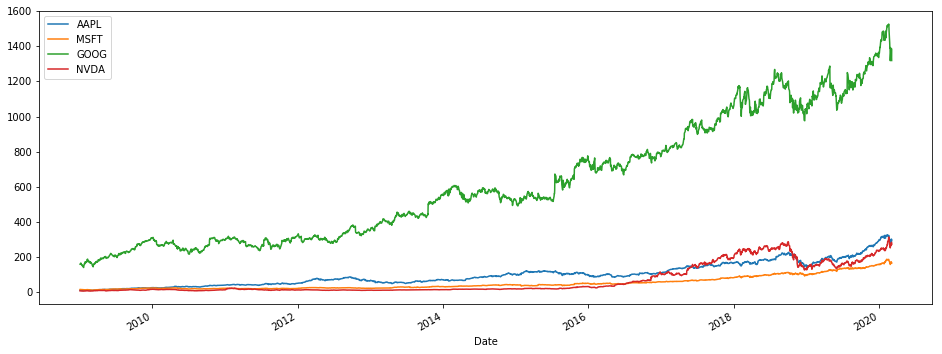

In [4]:
data.plot(figsize=(16,6))

In [5]:
port_daily_returns = data.pct_change()
port_daily_returns.mean()

AAPL    0.001303
MSFT    0.000963
GOOG    0.000875
NVDA    0.001614
dtype: float64

In [6]:
import numpy as np

In [7]:
np.random.seed(101)
number_of_ports = 4000
all_weights = np.zeros((number_of_ports, len(data.columns)))
all_returns = np.zeros(number_of_ports)
all_Vol = np.zeros(number_of_ports)
all_Sharp = np.zeros(number_of_ports)

for ind in range(number_of_ports):
    wei = np.array(np.random.random(4))
    wei = wei/wei.sum()
    all_weights[ind,:] = wei
    
    all_returns[ind] = np.sum(port_daily_returns.mean() * wei * 252)
    all_Vol[ind] = np.sqrt(np.dot(wei.T, np.dot(port_daily_returns.cov() * 252, wei)))
    all_Sharp[ind] = all_returns[ind]/all_Vol[ind]

In [8]:
sharp_max = all_Sharp.argmax()
sharp_max

2173

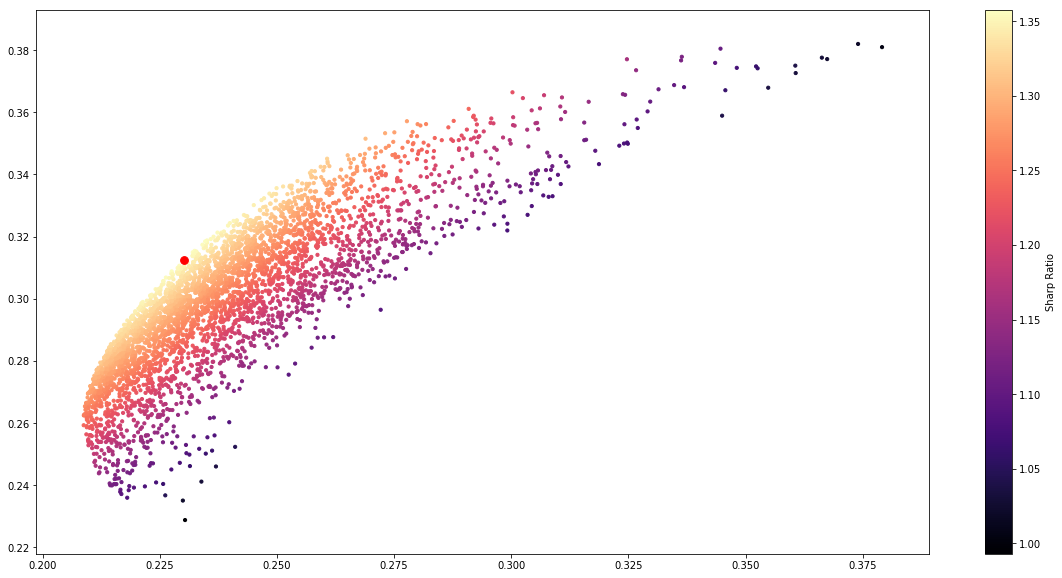

In [9]:
plt.figure(figsize=(20,10))
plt.scatter(all_Vol, all_returns, c = all_Sharp, cmap="magma", s=10)
plt.colorbar(label = "Sharp Ratio")
plt.scatter(all_Vol[sharp_max], all_returns[sharp_max], c = "red", s = 60)

### WE will move on from random alloctions to mathmatical optimiizaton

## we will need to 1st create a function that gets the exp return,vol, and sharp ratio based on passed weights 9Make sure its a np.array

In [19]:
from scipy.optimize import minimize

In [10]:
# initial function
def get_ret_vol_sharp(weights):
    weights = np.array(weights)
    ret = np.sum(port_daily_returns.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(port_daily_returns.cov() * 252, weights)))
    shar = ret/vol
    return np.array([ret,vol,shar])

## Helper functions

In [11]:
def min_sharp(weights):
    return get_ret_vol_sharp(weights)[2] * -1

In [12]:
def check_sum(weights):
    ## checks if the weights are == to zero
    return np.sum(weights) - 1

In [13]:
const = ({"type": "eq", "fun":check_sum})

In [16]:
bounds = ((0,1),) * len(data.columns)
bounds

((0, 1), (0, 1), (0, 1), (0, 1))

In [18]:
init_guess = [0.25] * len(data.columns)
init_guess

[0.25, 0.25, 0.25, 0.25]

In [20]:
opimal_results = minimize(min_sharp, init_guess, method="SLSQP", bounds= bounds, constraints=const)

In [21]:
opimal_results

     fun: -1.3577354028348079
     jac: array([ 0.00012578,  0.00022836,  0.00106622, -0.00115098])
 message: 'Optimization terminated successfully.'
    nfev: 31
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.53543179, 0.25385128, 0.05216383, 0.1585531 ])

### The above is the optimal Weights for each stock go the best sharp ratio. LEts get the vol and the return  this sharp using ou above function 

In [22]:
get_ret_vol_sharp(opimal_results.x)

array([0.31343389, 0.23085049, 1.3577354 ])

## WE see that we will get a sharp ratio as high as 1.35, col of 23% and a Return of 31. Matches out graph above as well. Below we will need to integrate the Efficient Frontier on the gaph to match our theory

In [39]:
frontier_y = np.linspace(0.23,0.40,100)

In [40]:
def min_vol(weights):
    return get_ret_vol_sharp(weights)[1]

In [41]:
frontier_vol = []

In [42]:
for possible_return in frontier_y:
    constt = ({"type": "eq", "fun": check_sum}, {"type": "eq", "fun": lambda w: get_ret_vol_sharp(w)[0] - possible_return})
    result = minimize(min_vol, init_guess,method="SLSQP", bounds=bounds, constraints=constt)
    frontier_vol.append(result["fun"])

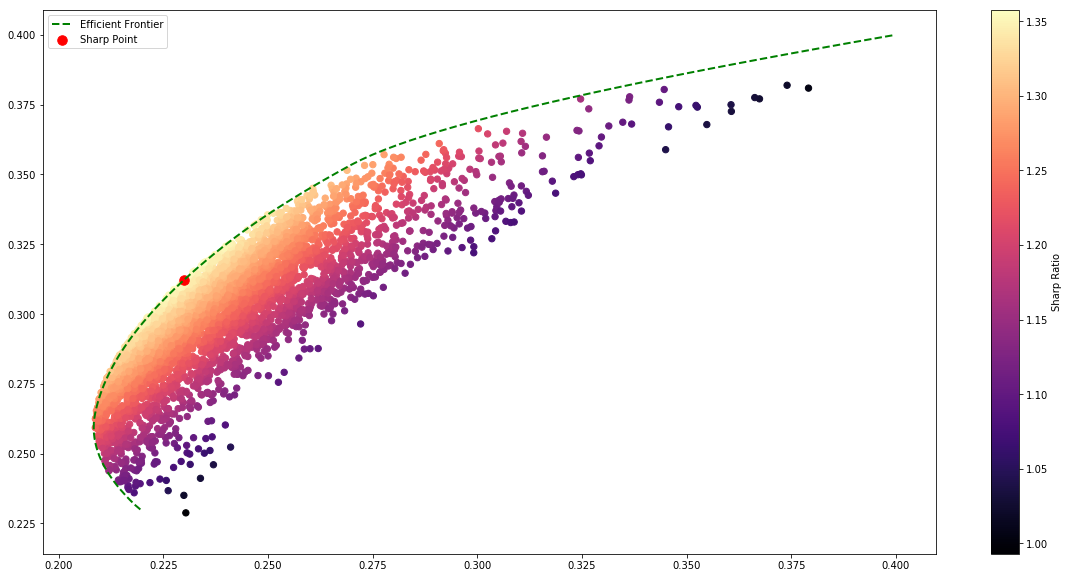

In [50]:
plt.figure(figsize=(20,10))
plt.scatter(all_Vol, all_returns, c = all_Sharp, cmap="magma", s=40)
plt.colorbar(label = "Sharp Ratio")
plt.scatter(all_Vol[sharp_max], all_returns[sharp_max], c = "red", s = 90, label = "Sharp Point")
plt.plot(frontier_vol,frontier_y, "g--", lw =2, label = "Efficient Frontier")
plt.legend()